## Final Project Submission

* **Student name:** Liz Alvarez
* **Student pace:** part time
* **Scheduled project review date/time:** Mon, March 9th at 2:30pm
* **Instructor name:** Abhineet Kulkarni
* **Blog post URL:** https://alvacat.github.io/project_credit_card_fraud_detection

## Credit Card Fraud Detection

### Goal
I will develop a model to detect fraudulent credit card transactions.  This allows credit card companies to determine which transactions are most likely not made by the customers which then allows the companies to stop the transaction, alert the customer, and cancel/reissue credit cards in a timely manner. 

### Background
The dataset was retrieved from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud. It includes all of the transactions made in a two-day time period in September 2013 by European cardholders.  To protect the privacy of the consumers, the dataset has already undergone PCA.  There are 28 principal components (V1-V28) along with a time column (the number of seconds between transactions) and the amount of the transaction.  The class column is a binary classification: 1 for a fraudulent transaction and 0 for genuine transaction.

### References
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. *Calibrating Probability with Undersampling for Unbalanced Classification.* In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. *Learned lessons in credit card fraud detection from a practitioner perspective,* Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. *Credit card fraud detection: a realistic modeling and a novel learning strategy*, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea *Adaptive Machine learning for credit card fraud detection* ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. *Scarff: a scalable framework for streaming credit card fraud detection with Spark*, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. *Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization*, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi *Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection*, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi *Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection* Information Sciences, 2019

## Data Analysis

### Libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

### Functions

In [2]:
def fit_and_predict(model,X_train,y_train,X_test):
    """Fits a given model and generates predictions for the testing and training sets.
    
    Returns: testing predictions, training predictions.

    Keyword arguments:
    model -- an instance of the model that will be fit to the data
    X_train -- the data that the model will be built on.  Typically, these are from the training set.
    y_train -- the target that the model will be built on.  Typically, this is from the training set.
    X_test -- the data that the model will use to generate predictions for the target.  Typically from the testing set.
    
    """
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_train_pred=model.predict(X_train)
    return y_pred,y_train_pred

def evaluate(model,true,pred,train=False):
    """Evaluates a model using accuracy, F1, precision, and recall scores.
    
    Returns: accuracy, F1, precision, recall

    Keyword arguments:
    model -- an instance of the model that will be fit to the data
    true -- the actual values for the target
    pred -- the predicted values for the target
    train -- determines whether 'Test Values' or 'Train Values' will be printed above the results. default: False.
    """
    acc=accuracy_score(true,pred)
    f1=f1_score(true,pred)
    prec=precision_score(true,pred)
    recall=recall_score(true,pred)
    if train==False:
        print('---Test values---')
    else:
        print('---Train values---')
    print(f'Accuracy: {acc}')
    print(f'F1:{f1}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    return acc,f1,prec,recall

def best_params(model,param_grid):
    """Uses a grid search to determine the optimal parameters for a model. The grid search uses a 3-fold cross-validation.
    
    Returns: best parameters

    Keyword arguments:
    model -- an instance of the model that will be fit to the data
    param_grid -- the parameter grid that will be tested    
    """
    print("Performing grid search...")
    grid_search=GridSearchCV(model,param_grid,cv=3,return_train_score=True)
    grid_search.fit(X_train,y_train)
    print("Determining Best Parameters...")
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test,y_test)
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)
    return grid_search.best_params_

In [3]:
#loading the data
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#checking for null values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
#checking for class sizes
fraud=int(df.Class.sum())
real=len(df.Class)-fraud
print(f'Fraudulent charges: {round(fraud/len(df)*100,2)}% ({fraud} out of {len(df)})')
print(f'Genuine charges: {round(real/len(df)*100,2)}% ({real} out of {len(df)})')

Fraudulent charges: 0.17% (492 out of 284807)
Genuine charges: 99.83% (284315 out of 284807)


The classes are wildly imbalanced (as expected, really, since most charges aren't fraudulent).  After I split the testing and training sets, I'm going to use SMOTE to oversample the fraudulent charges and I'll also undersample the genuine charges to get a more balanced set of classes.

In [6]:
#separating the testing/training data
X=df.drop('Class',axis=1)
y=df['Class']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2)

In [7]:
#checking testing/training data to ensure a similar makeup to the original dataset
train_fraud=int(y_train.sum())
train_real=len(y_train)-fraud
test_fraud=int(y_test.sum())
test_real=len(y_test)-fraud
print('Training Set')
print(f'Fraudulent charges: {round(train_fraud/len(y_train)*100,2)}% ({train_fraud} out of {len(y_train)})')
print(f'Genuine charges: {round(train_real/len(y_train)*100,2)}% ({train_real} out of {len(y_train)})\n')
print('Testing Set')
print(f'Fraudulent charges: {round(test_fraud/len(y_test)*100,2)}% ({test_fraud} out of {len(y_test)})')
print(f'Genuine charges: {round(test_real/len(y_test)*100,2)}% ({test_real} out of {len(y_test)})\n')

Training Set
Fraudulent charges: 0.17% (398 out of 227845)
Genuine charges: 99.78% (227353 out of 227845)

Testing Set
Fraudulent charges: 0.17% (94 out of 56962)
Genuine charges: 99.14% (56470 out of 56962)



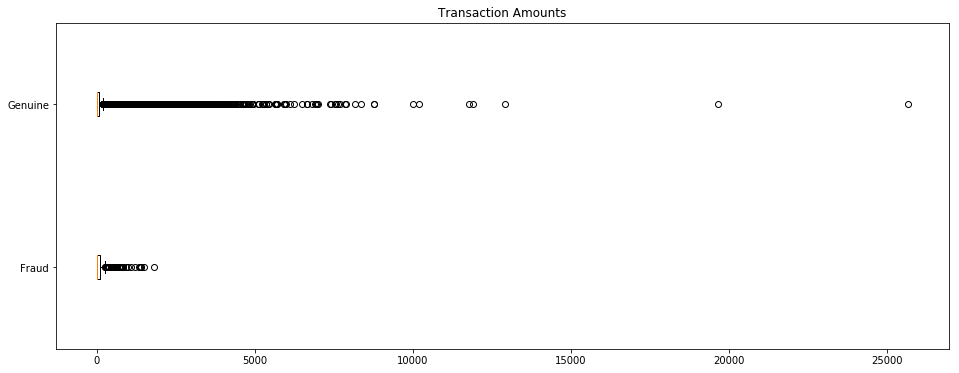

In [8]:
fraud_train_indices=np.array(y_train[y_train==1].index)
fraud_amounts=[X_train.Amount[x] for x in fraud_train_indices]
good_train_indices=np.array(y_train[y_train==0].index)
good_amounts=[X_train.Amount[x] for x in good_train_indices]
plt.figure(figsize=(16,6))
plt.boxplot([fraud_amounts,good_amounts],vert=False,labels=["Fraud","Genuine"])
plt.title('Transaction Amounts');

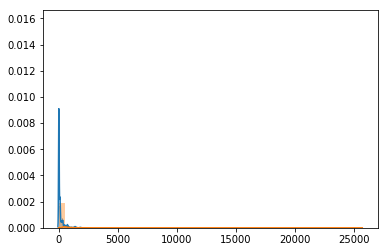

In [9]:
sns.distplot(fraud_amounts)
sns.distplot(good_amounts)

In [10]:
train_df=X_train.join(y_train)

In [11]:
train_df.Amount.describe()

count    227845.000000
mean         88.469989
std         252.199346
min           0.000000
25%           5.640000
50%          22.000000
75%          77.350000
max       25691.160000
Name: Amount, dtype: float64

In [12]:
IQR=train_df.Amount.quantile(.75)-train_df.Amount.quantile(0.25)
upper_bound=train_df.Amount.quantile(.75)+1.5*IQR
rows_to_drop=train_df.loc[train_df.Amount>upper_bound].index
train_df.drop(rows_to_drop,inplace=True)
train_df.Amount.describe()

count    202368.000000
mean         35.060113
std          42.262659
min           0.000000
25%           4.490000
50%          16.150000
75%          49.990000
max         184.910000
Name: Amount, dtype: float64

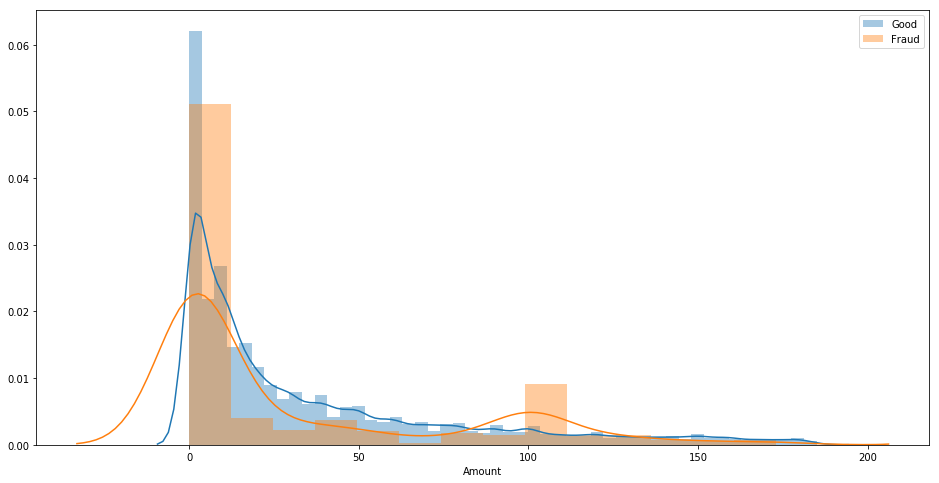

In [13]:
good=train_df.loc[train_df.Class==0].Amount
fraud=train_df.loc[train_df.Class==1].Amount
plt.figure(figsize=(16,8))
sns.distplot(good,label="Good")
sns.distplot(fraud,label="Fraud")
plt.legend();

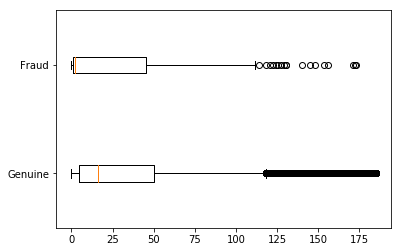

In [14]:
plt.boxplot([good,fraud],vert=False,labels=['Genuine','Fraud']);

In [15]:
good.value_counts().head()

1.00     10844
1.98      4882
0.89      3887
9.99      3787
15.00     2617
Name: Amount, dtype: int64

In [16]:
fraud.value_counts().head()

1.00     92
99.99    25
0.00     21
0.76     14
0.77      6
Name: Amount, dtype: int64

So, from some basic plots I can see that fraudulent charges generally have smaller amounts than genuine ones (but that's not true in every case and it's certainly not enough info to be able to accurately detect fraud).

### Balancing the Classes

I'm going to oversample the fradulent charges using SMOTE.

In [17]:
#creating instance for oversampling
oversample=SMOTE()

In [18]:
#oversampling
X_train_resampled,y_train_resampled=oversample.fit_resample(X_train,y_train)

In [19]:
resample_train_fraud=int(y_train_resampled.sum())
resample_train_real=len(y_train_resampled)-resample_train_fraud
print('Resampled Training Set')
print(f'Fraudulent charges: {round(resample_train_fraud/len(y_train_resampled)*100,2)}% ({resample_train_fraud} out of {len(y_train_resampled)})')
print(f'Genuine charges: {round(resample_train_real/len(y_train_resampled)*100,2)}% ({resample_train_real} out of {len(y_train_resampled)})\n')

Resampled Training Set
Fraudulent charges: 50.0% (227447 out of 454894)
Genuine charges: 50.0% (227447 out of 454894)



The percentage of fradulent charges has increased from about 0.17% to 50% so the classes are much more balanced now.

### Making Models

I'm going to try a few different models and compare them, then I'll tweak the hyperparameters for the best two or three models.  Finally, I'll pick the tuned model that performs best.

In [20]:
#Instantiating all the Models

#Logistic
log_reg=LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

#Decision Tree
tree_clf=DecisionTreeClassifier()

#Bag of Trees
bagged_trees=BaggingClassifier(DecisionTreeClassifier())

#Random Forest
forest=RandomForestClassifier()

#Adaboost
ada_clf=AdaBoostClassifier()

#Gradient Boost
gb_clf=GradientBoostingClassifier()

#XGBoost
xgb_clf=XGBClassifier()

In [21]:
#Fitting and Testing the Models
models=[('Logistic Regression',log_reg),('Decision Tree',tree_clf),('Bagged Trees',bagged_trees),
        ('Random Forest',forest),('ADA Boost',ada_clf),('Gradient Boost',gb_clf),('XGBoost',xgb_clf)]

In [22]:
for model in models:
    y_pred,y_train_pred=fit_and_predict(model[1],X_train,y_train,X_test)
    print(f'\n{model[0]} Statistics\n')
    train_acc,train_f1,train_prec,train_recall=evaluate(model,y_train,y_train_pred,train=True)
    print('')
    acc,f1,prec,recall=evaluate(model,y_test,y_pred)
    print('\nConfusion Matrix')
    print(confusion_matrix(y_test,y_pred))
    print('')
    print('~'*30)


Logistic Regression Statistics

---Train values---
Accuracy: 0.9983804779565055
F1:0.5653710247349822
Precision: 0.532150776053215
Recall: 0.6030150753768844

---Test values---
Accuracy: 0.9985253326779256
F1:0.58
Precision: 0.5471698113207547
Recall: 0.6170212765957447

Confusion Matrix
[[56820    48]
 [   36    58]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Decision Tree Statistics

---Train values---
Accuracy: 1.0
F1:1.0
Precision: 1.0
Recall: 1.0

---Test values---
Accuracy: 0.9992977774656788
F1:0.7752808988764044
Precision: 0.8214285714285714
Recall: 0.7340425531914894

Confusion Matrix
[[56853    15]
 [   25    69]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Bagged Trees Statistics

---Train values---
Accuracy: 0.9999034431301982
F1:0.9717223650385605
Precision: 0.9947368421052631
Recall: 0.949748743718593

---Test values---
Accuracy: 0.9995786664794073
F1:0.8588235294117647
Precision: 0.9605263157894737
Recall: 0.776595744680851

Confusion Matrix
[[56865     3]
 [   21    73]]

~~~~~~~~~~~~~~~~~

ActualPredicted  
G=genuine  
F=fraud  

Confusion Matrix Key  
GG    GF    
FG    FF  

Based on the results above, it looks like the best two models are Random Forest and XGBoost. I've chosen those two as the best for two big reasons:
- they have a low number of false negatives.  When looking for fraud, it's better to be a little too suspicious instead of not suspicious enough.  If a genuine transaction is flagged as potentially fradulent, a quick call with the customer can clear it up.  If a fraudulent transaction is missed though, no one may notice what's happened for a loooooooong time.  So, false positives are way less important than false negatives.
- they have a high recall.  This is another way of looking for false negatives, really.  Recall shows how many of the actual positives (i.e. fraudulent charges) the model catches.  The higher recall, the better.

and one smaller reason:
- their F1 scores are decent.  F1 shows how well the model is balanced between false positives and false negatives. A model could have a high recall by flagging every transaction as potential fraud.  However, a high F1 score shows that the model is being more discriminating than that.  It's actually (somewhat) intelligently classifying the transactions so that'll help minimize the number of customers freaked out by calls about suspicious activity on their account.

The Bagged Trees model is pretty close in performance to the Random Forest and, computationally, it goes a little faster so it could be worth choosing Bagged Trees over Random Forest if computational power is an issue.  However, since I'm looking at detecting fraud, I'm willing to spend a little extra calculation effort.

It's also worth noting that most of the models I ran are based on decision trees.  So, my models were:
- **Logistic**: a log (get it? *ba dum tsh*)
- **Decision Tree**: a tree
- **Bagged Trees**: a bag full of trees
- **Random Forest**: a forest full of trees
- **ADABoost**: a topiary garden of trees
<img src='topiary.jpg' width=400>
<center><i>Topiary garden! Credit: https://www.flickr.com/photos/joaomaximo/214299348</i></center>
- **Gradient Boost**: a different topiary garden of trees
- **XGBoost**: an arbotecture garden of trees
<img src="Needle_n_thread.jpg">
<center><i>Arbortecture! Basically the same as XGBoost. Credit- http://www.arborsmith.com</i></center>


### Improving the Models

The next thing I'm going to do is try to improve the top two models.  I'm going to use a grid search to narrow in on some better values for the hyperparameters to see what happens to each model.

In [23]:
#grid search
rf_param_grid={'n_estimators':[10,100],
              'max_depth':[None,5]}

xgb_param_grid={'max_delta_step':[1,10],
               'tree_method':['approx','hist']}

In [24]:
best_params(forest,rf_param_grid)

Performing grid search...
Determining Best Parameters...
Mean Training Score: 99.97%
Mean Test Score: 99.95%
Best Parameter Combination Found During Grid Search:
{'max_depth': None, 'n_estimators': 100}


{'max_depth': None, 'n_estimators': 100}

Well...those are the default values for the Random Forest Classifier.

In [25]:
new_forest=RandomForestClassifier(n_estimators=100,max_depth=None)
y_pred,y_train_pred=fit_and_predict(new_forest,X_train,y_train,X_test)
print(f'Improved Random Forest\n')
train_acc,train_f1,train_prec,train_recall=evaluate(new_forest,y_train,y_train_pred,train=True)
print('')
acc,f1,prec,recall=evaluate(new_forest,y_test,y_pred)
print('\nConfusion Matrix')
print(confusion_matrix(y_test,y_pred))

Improved Random Forest

---Train values---
Accuracy: 0.9999912221027453
F1:0.9974811083123425
Precision: 1.0
Recall: 0.9949748743718593

---Test values---
Accuracy: 0.9995611109160493
F1:0.8538011695906432
Precision: 0.948051948051948
Recall: 0.776595744680851

Confusion Matrix
[[56864     4]
 [   21    73]]


Now I'll do a grid search on the XGBoost model.

In [26]:
best_params(xgb_clf,xgb_param_grid)

Performing grid search...
Determining Best Parameters...
Mean Training Score: 99.96%
Mean Test Score: 99.95%
Best Parameter Combination Found During Grid Search:
{'max_delta_step': 1, 'tree_method': 'approx'}


{'max_delta_step': 1, 'tree_method': 'approx'}

The `max_delta_step` isn't the default (which is 0, but that wasn't an option for my grid either) but the tree method is the default value.

In [27]:
new_xgb=XGBClassifier(max_delta_step=1,tree_method='approx')
y_pred,y_train_pred=fit_and_predict(new_xgb,X_train,y_train,X_test)
print(f'Improved XGBoost\n')
train_acc,train_f1,train_prec,train_recall=evaluate(new_xgb,y_train,y_train_pred,train=True)
print('')
acc,f1,prec,recall=evaluate(new_xgb,y_test,y_pred)
print('\nConfusion Matrix')
print(confusion_matrix(y_test,y_pred))

Improved XGBoost

---Train values---
Accuracy: 0.9995962167262832
F1:0.8763440860215054
Precision: 0.9421965317919075
Recall: 0.8190954773869347

---Test values---
Accuracy: 0.9995259997893332
F1:0.8457142857142856
Precision: 0.9135802469135802
Recall: 0.7872340425531915

Confusion Matrix
[[56861     7]
 [   20    74]]


So, the models both stayed the same, which isn't surprising since my grid searches were tiny.  Both models performed similarly to each other, too, so I'm just going to focus on the XGBoost (because it runs slightly faster than the Random Forest model).

I'm going to pick a couple parameters and do some more tweaking.

In [28]:
#pick a parameter and run through 10 values of it
etas=np.linspace(0,1,10)

#fit the model with each value of the parameter, recording the recall score for each
test_recalls=[]
train_recalls=[]
for eta in etas:
    xgb_tweak=XGBClassifier(max_delta_step=0,tree_method='approx',eta=eta)
    y_pred,y_train_pred=fit_and_predict(xgb_tweak,X_train,y_train,X_test)
    test_recall=recall_score(y_test,y_pred)
    train_recall=recall_score(y_train,y_train_pred)
    test_recalls.append(test_recall)
    train_recalls.append(train_recall)

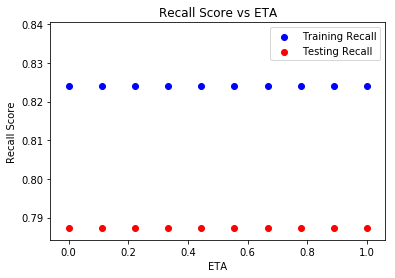

In [29]:
#plot the recall scores vs the eta values
plt.scatter(etas,train_recalls,label="Training Recall",color="blue")
plt.scatter(etas,test_recalls,label="Testing Recall",color="red")
plt.title("Recall Score vs ETA")
plt.xlabel("ETA")
plt.ylabel("Recall Score")
plt.legend();

In [30]:
test_recalls

[0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915,
 0.7872340425531915]

So the eta value doesn't seem to matter.  Cool.

Now, I'm going to do the same thing for the maximum tree depth parameter.

In [31]:
#pick a parameter and run through 10 values of it
depths=np.linspace(1,10,10,dtype='int')

#fit the model with each value of the parameter, recording the recall score for each
test_recalls=[]
train_recalls=[]
for depth in depths:
    xgb_tweak=XGBClassifier(max_delta_step=0,tree_method='approx', max_depth=depth)
    y_pred,y_train_pred=fit_and_predict(xgb_tweak,X_train,y_train,X_test)
    test_recall=recall_score(y_test,y_pred)
    train_recall=recall_score(y_train,y_train_pred)
    test_recalls.append(test_recall)
    train_recalls.append(train_recall)

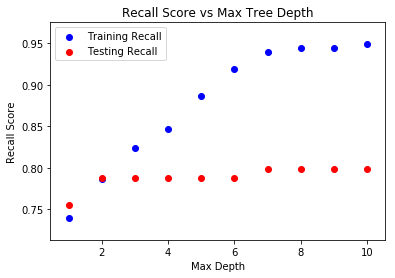

In [32]:
#plot the recall scores vs the max_depth values
plt.scatter(depths,train_recalls,label="Training Recall",color="blue")
plt.scatter(depths,test_recalls,label="Testing Recall",color="red")
plt.title("Recall Score vs Max Tree Depth")
plt.xlabel("Max Depth")
plt.ylabel("Recall Score")
plt.legend();

This graph tells me that the best value for `max_depth` is 2.  The training recall score continues to increase after that but the testing recall (which is more important) peaks at a depth of 2 and then decreases. (The default setting for `max_depth` is 6, in case you were curious.)

And, for one final parameter, I'm going to look at `subsample` (the percentage of the training set that the algorithm looks at to create the model).

In [34]:
#pick a parameter and run through 10 values of it
subsamples=np.linspace(0,1,10)

#fit the model with each value of the parameter, recording the recall score for each
test_recalls=[]
train_recalls=[]
for sample in subsamples:
    xgb_tweak=XGBClassifier(max_delta_step=0,tree_method='approx', max_depth=2, subsample=sample)
    y_pred,y_train_pred=fit_and_predict(xgb_tweak,X_train,y_train,X_test)
    test_recall=recall_score(y_test,y_pred)
    train_recall=recall_score(y_train,y_train_pred)
    test_recalls.append(test_recall)
    train_recalls.append(train_recall)

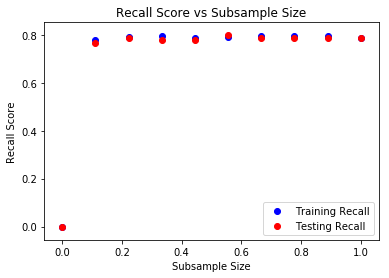

In [35]:
#plot the recall scores vs the subsample values
plt.scatter(subsamples,train_recalls,label="Training Recall",color="blue")
plt.scatter(subsamples,test_recalls,label="Testing Recall",color="red")
plt.title("Recall Score vs Subsample Size")
plt.xlabel("Subsample Size")
plt.ylabel("Recall Score")
plt.legend();

In [36]:
print(list(zip(subsamples,test_recalls)))

[(0.0, 0.0), (0.1111111111111111, 0.7659574468085106), (0.2222222222222222, 0.7872340425531915), (0.3333333333333333, 0.776595744680851), (0.4444444444444444, 0.776595744680851), (0.5555555555555556, 0.7978723404255319), (0.6666666666666666, 0.7872340425531915), (0.7777777777777777, 0.7872340425531915), (0.8888888888888888, 0.7872340425531915), (1.0, 0.7872340425531915)]


This graph tells me that the best value for `subsample` is 0.5555 (or 5/9ths).  The recall score tops out there and then doesn't benefit anymore from increasing the ratio of the training data that's sampled to create the model.

I'm going to use the values I found from the grid search and from individually tuning the parameters to refit the model and then I'll do some final analysis on it.

In [37]:
#refit model again
xgb_final=XGBClassifier(max_delta_step=0,tree_method='approx',max_depth=2,subsample=5/9)
y_pred,y_train_pred=fit_and_predict(xgb_final,X_train,y_train,X_test)
train_acc,train_f1,train_prec,train_recall=evaluate(xgb_final,y_train,y_train_pred,train=True)
print('')
acc,f1,prec,recall=evaluate(xgb_final,y_test,y_pred)
print('\nConfusion Matrix')
print(confusion_matrix(y_test,y_pred))

---Train values---
Accuracy: 0.9994996598564814
F1:0.8463611859838275
Precision: 0.9127906976744186
Recall: 0.7889447236180904

---Test values---
Accuracy: 0.9995435553526912
F1:0.8522727272727272
Precision: 0.9146341463414634
Recall: 0.7978723404255319

Confusion Matrix
[[56861     7]
 [   19    75]]


Here are the vanilla XGBoost model statistics (so you don't have to scroll back up to see them).

---Train values---  
Accuracy: 0.9996752178015756  
F1:0.901595744680851  
Precision: 0.9630681818181818  
Recall: 0.8475  

---Test values---  
Accuracy: 0.9995084442259752  
F1:0.8372093023255814  
Precision: 0.9  
Recall: 0.782608695652174  

Confusion Matrix  
[[56862     8]  
 [   20    72]]

The F1 score has improved 1 percent (0.837 to 0.852) and the recall has also increased a tiny bit (0.782 to 0.798).  The number of false negatives dropped (from 20 to 19) but the number of false positives has also decreased (8 to 7).  The good news is that the number of true negatives has also increased (from 72 to 75).  So, a minor change overall but those three extra people will be pretty grateful for those charges being detected.

Now, to look at some more metrics.

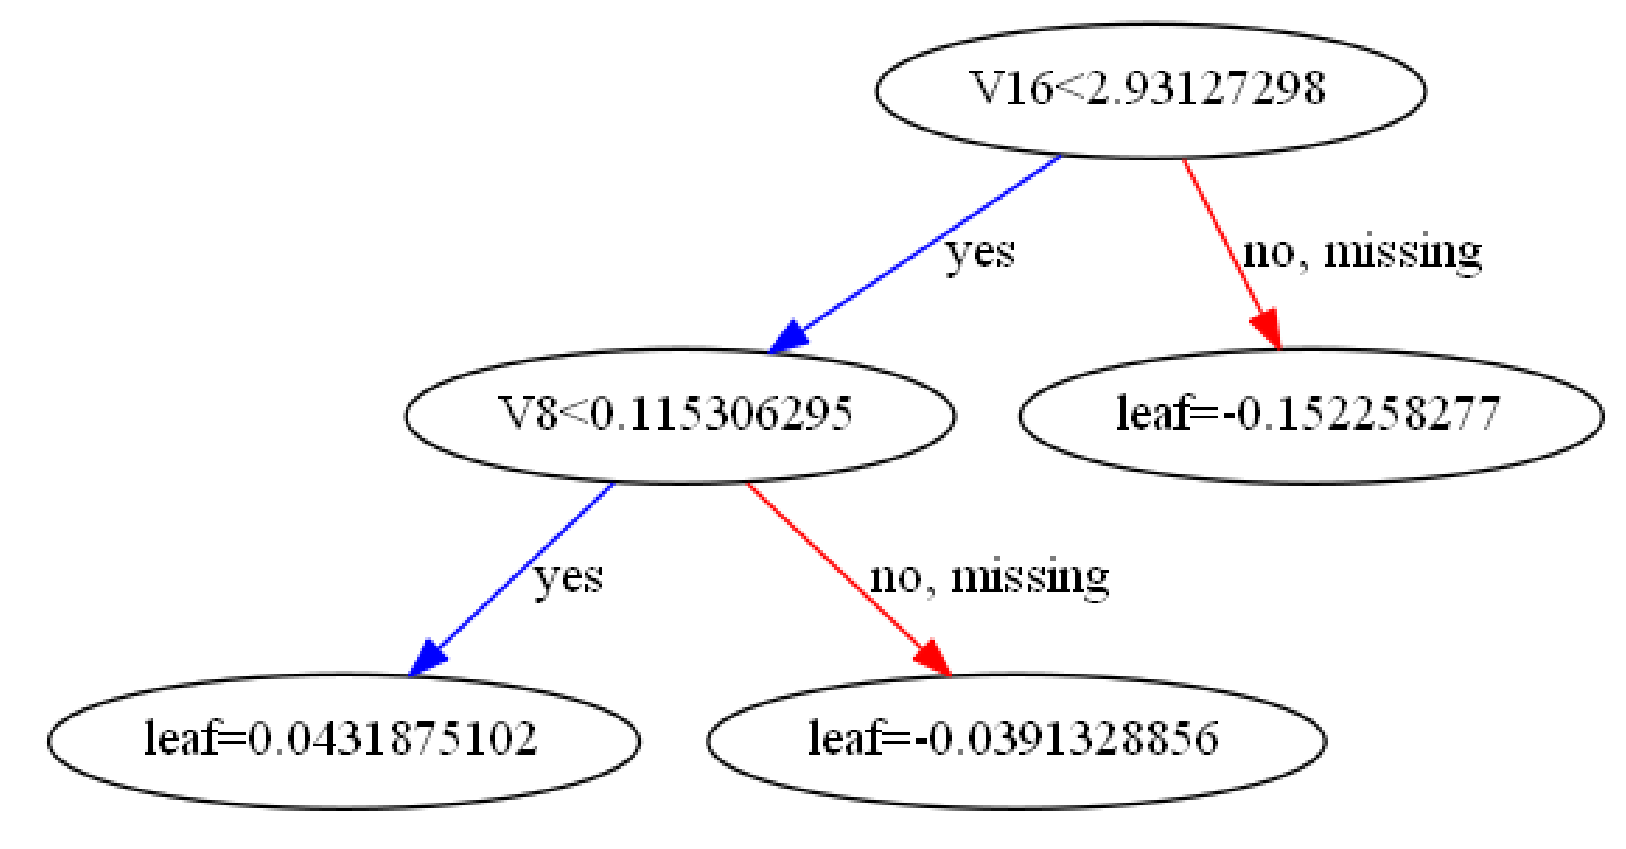

In [40]:
#Look at a tree
xgboost.plot_tree(xgb_final,num_trees=99)
plt.rcParams['figure.figsize'] = [75, 15]
plt.show();

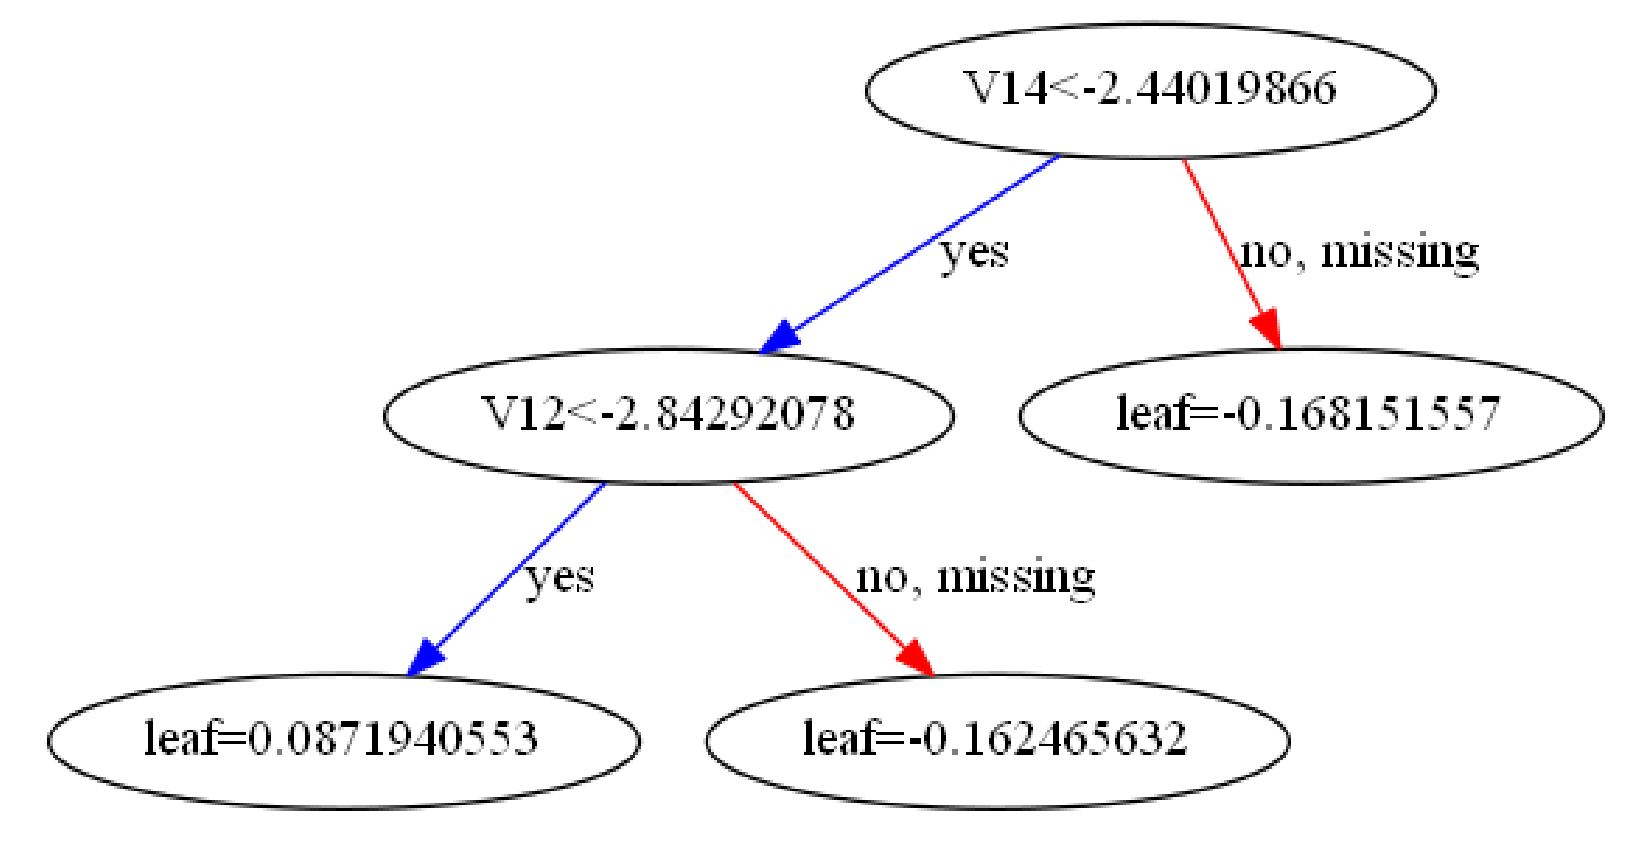

In [39]:
#look at a different tree
xgboost.plot_tree(xgb_final,num_trees=2)
plt.show();

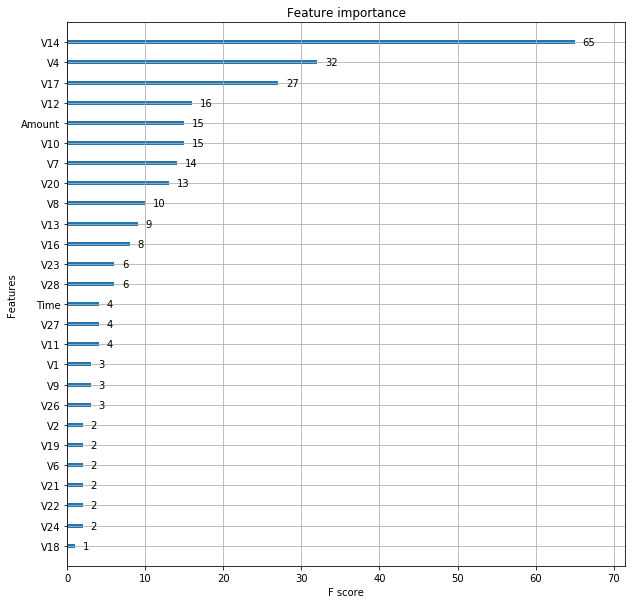

In [57]:
#look at important features
xgboost.plot_importance(xgb_final)
plt.rcParams.update({'figure.figsize':(50, 50)})
plt.show();

The above graph shows that feature V14 is the best predictor of fraud, followed by V4 and V17.  The amount of the transaction is the 5th most important predictor.

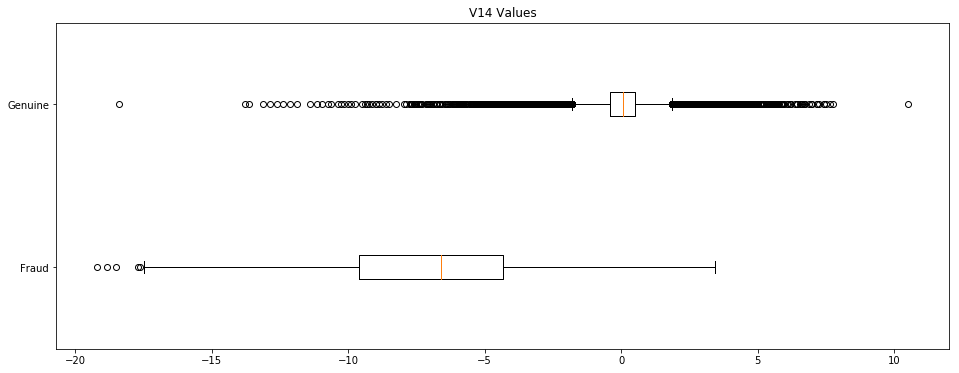

In [58]:
#make a set of boxplots to compare V14 values for fraud/genuine transactions
fraud_train_indices=np.array(y_train[y_train==1].index)
fraud_amounts=[X_train.V14[x] for x in fraud_train_indices]
good_train_indices=np.array(y_train[y_train==0].index)
good_amounts=[X_train.V14[x] for x in good_train_indices]
plt.figure(figsize=(16,6))
plt.boxplot([fraud_amounts,good_amounts],vert=False,labels=["Fraud","Genuine"])
plt.title('V14 Values');

The boxplots confirm that the V14 values for fraudulent transactions tend to be much lower than for genuine transactions. The 3rd quartile for the fraud boxplot is significantly lower than the lower outlier limit for the genuine transactions. That means that more than 75% of fraudulent transactions fall below the "normal" limits of the genuine transactions.

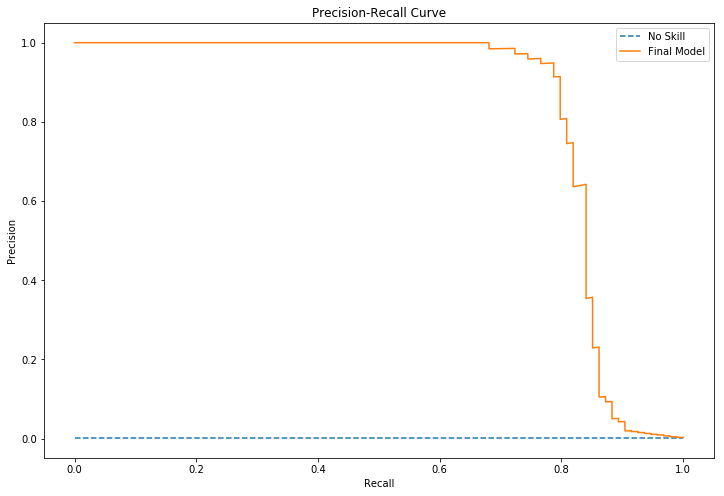

In [59]:
#Plotting the Precision-Recall curve (which is more accurate that ROC/AUC for imbalanced classes)
xgb_prob=xgb_final.predict_proba(X_test)
xgb_prob=xgb_prob[:,1]
precision,recall,_=precision_recall_curve(y_test,xgb_prob)
no_skill=len(y_test[y_test==1])/len(y_test)
plt.figure(figsize=(12,8))
plt.plot([0,1],[no_skill,no_skill],linestyle='--',label='No Skill')
plt.plot(recall,precision,label="Final Model")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title("Precision-Recall Curve")
plt.show();

The Precision-Recall curve looks pretty good. The precision is fairly high until the recall gets up to 0.8 so that indicates the model does a good job at balancing false positives and false negatives and, if it has to choose, it picks increasing false positives (which decreases precision) to decrease the false negatives (thereby increasing the recall).

## Conclusion

Using XGBoost with some tuned hyperparameters gives a pretty good model.  It's hard to give very specific business suggestions since the data had already undergone PCA. 

I can suggest that:
- component V14 is the most important feature when it comes to predicting fradulent transactions so this could be a first line defense for quickly detecting fraud. If the V14 value is below approximately -1, the transaction could be flagged as suspicious and then be submitted for further testing at which point the lengthier/more in-depth model could be used.
- the amount of the transaction is not actually a great predictor of the authenticity of a charge.  This suggests that having blanket policies (such as freezing a customer's card for purchases above, say, `$600` is not actually effective at stopping/preventing fraudulent transactions).
- it's better to have more false positives than false negatives.  Missing fraud has a lot more repercussions than accidentally stopping genuine charges.
- More info is needed about:
 - what the original features of the dataset were.  It's difficult to make specific and worthwhile suggestions with data that's undergone PCA already. Consider other options for protecting the privacy of customers while still being transparent with the data. There are many questions that could provide a lot of useful insights: Are a customer's previous transactions considered?  etc.
 - how the data was preprocessed.  How was the data cleaned/processed before PCA was performed? Clearly, PCA was performed on the entire dataset. That can lead to information bleeding between the training/test sets and can thus influence the final model. If PCA absolutely must be done before sharing the data, consider splitting the data into testing/training sets first and then building the PCA on the training set (and then transforming the testing set in exactly the same way). Then the testing and training sets can be shared separately.  This will lead to a more robust model.